# DFT mit Rechteckfensterung
Im letzten Kapitel hatten wir uns mit der DFT beschäftigt von Vorgängen, die entweder vollständig in das Messfenster passen oder die sich fehlerfrei rekonstruieren lassen durch periodische Wiederholung des Signals im Messfenster
(gefenstertes Signal). In diesem Fall stimmt die DFT des abgetasteten, gefensterten Signals an den Frequenzpunkten mit dem Spektrum des zeitkontinuierlichen Signals überein.

Im Allgemeinen ist dies nicht möglich, weil man die Periode des Signals vorab nicht kennt oder Abtastfrequenz und / oder Anzahl der DFT-Punkte nicht frei wählbar sind. Dieses Notebook zeigt, dass die periodische Fortsetzung des gefensterten Signals im Zeitbereich dann nicht identisch mit dem ursprünglichen periodischen Signal ist und dementsprechend das Spektrum gegenüber dem des ursprünglichen Signals verfälscht ist.

In [5]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
    
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import linspace, log10, cos, sin, pi
from numpy.fft import fft, fftshift, fftfreq
import scipy.signal as sig

figsize = {"figsize":(13,9)}

def stems(x, y, ax=None, label=None, s=20, **kwargs):
    """ A faster and more flexible replacement for stem plot"""
    bottom=kwargs.pop('bottom', 0) # pop the 'bottom' key-value pair from the dict (default: 0)
    ax.axhline(bottom, **kwargs)
    ax.vlines(x, y, bottom, label=label, **kwargs)
    ax.scatter(x,y,**kwargs, s=s)

Aus einer periodischen (unendlichen) Datenfolge $y[n]$ schneiden wir $N_{FFT}$ Datenpunkte im Zeitbereich aus und erhalten $y_w[n]$. Die DFT von $y_w[n]$ liefert uns $N_{FFT}$ Frequenzpunkte. **Wenn** die periodische Fortsetzung von $y_w[n]$ das ursprüngliche Signal $y[n]$ ergibt, d.h. wenn sich die $N_{FFT}$ Datenpunkte periodisch wiederholen, liefert die **DTFT** exakt das gleiche Ergebnis wie die DFT.

Die Länge des Messfensters $T_{mess} = T_S N_{FFT}$ und die Frequenzauflösung $\Delta f = f_S / N_{FFT} = 1 / T_{mess}$ ergeben sich automatisch aus Abtastfrequenz $f_S = 1/T_S$ und der Zahl der FFT-Punkte:

In [6]:
f_S = 1e5; T_S = 1./f_S  # Abtastfrequenz und -periode
N_FFT = 50               # Anzahl FFT Punkte
T_meas = T_S * N_FFT     # Dauer des Messfensters
Delta_f = f_S / N_FFT    # Frequenzauflösung
L = 3                    # Zeige L Messfenster 
OSR = 500                # "Oversampling Ratio" für Anzeige des pseudo-analogen Signals
 
t = linspace(0,T_meas*L, N_FFT * OSR*L, endpoint=False) # "analoge" Zeit über L Fenster
n = np.arange(0, N_FFT*L)                               # diskrete Zeitpunkte über L Fenster

print('T_meas = {0}s \t Delta f = {1} Hz'.format(T_meas, 1/T_meas))

T_meas = 0.0005s 	 Delta f = 2000.0 Hz


Wir erzeugen uns ein "analoges" Testsignal mit zwei Tönen unterschiedlicher Frequenz $f_a$, $f_b$ und Amplitude $A_a$, $A_b$ über eine Gesamtzeitdauer von $L T_{meas}$ und plotten es über die Gesamtdauer von $L$ Messfenstern. Das eigentliche Fenster ist grau hinterlegt:

f_a =  6000.0 Hz	 f_b =  19000.0 Hz


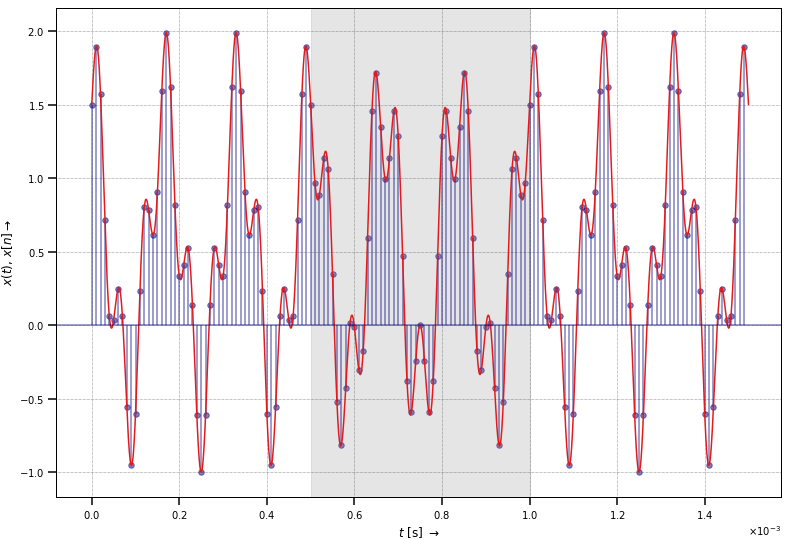

In [7]:
A_a = 1; f_a = Delta_f * 3      # Ton a, genau auf Auswertefrequenz
A_b = 0.5; f_b = Delta_f * 9.5  # Ton b, zwischen Auswertefrequenzen
DC = 0.5
print('f_a = ', f_a, 'Hz\t f_b = ', f_b, 'Hz')

def x(t): # Definiere Signalfunktion
    return DC + A_a * cos(2 * pi * t * f_a) + A_b * sin(2 * pi * t * f_b)

xt = x(t) # x(t)
fig1, ax1 = plt.subplots(**figsize)
ax1.plot(t, xt)
stems(n*T_S, x(n*T_S), ax=ax1, s=30, color=(0.0,0,0.5,0.5), bottom=0) #"abgetastetes" Signal
ax1.axvspan(t[N_FFT*OSR],t[(2*N_FFT)*OSR-1], alpha=0.2, color='grey') # plotte Fenster
ax1.set_xlabel(r'$t$ [s] $\rightarrow $');ax1.set_ylabel(r'$x(t),\, x[n] \rightarrow $');

# Nochmal!
Wir schneiden jetzt hart (Profis sagen mit einem "Rechteck-" oder "Boxcarfenster") $N_{FFT}$ Samples aus dem Signal $x[n]$ aus und wiederholen die resultierende Folge $x_w[n]$ (wiederum grau hinterlegt) periodisch. Das dient nur zur Visualisierung, in der Realität hat man nur die Folge $x_w[n]$ mit  $N_{FFT}$ Samples zur Verfügung.

Wir berechnen die DFT der gefensterten Funktion, berechnen deren Absolutwert und skalieren die DFT mit dem Faktor $2/N_{FFT}$. Mit dieser Skalierung sind die Gesamtleistung bei einseitiger Spektraldarstellung im Frequenzbereich und im Zeitbereich identisch (Parcevalsche Beziehung).

Das Spektrum der "analogen" Funktion wird angenähert über eine DFT des ungefensterten Signals über $100 T_{meas}$, daraus resultiert eine Frequenzauflösung von $\Delta f = (100 T_{meas})^{-1}$. Eine Erhöhung der Abtastrate verbessert *nicht* die Frequenzauflösung, damit erhöht man nur die maximal darstellbare Frequenz.

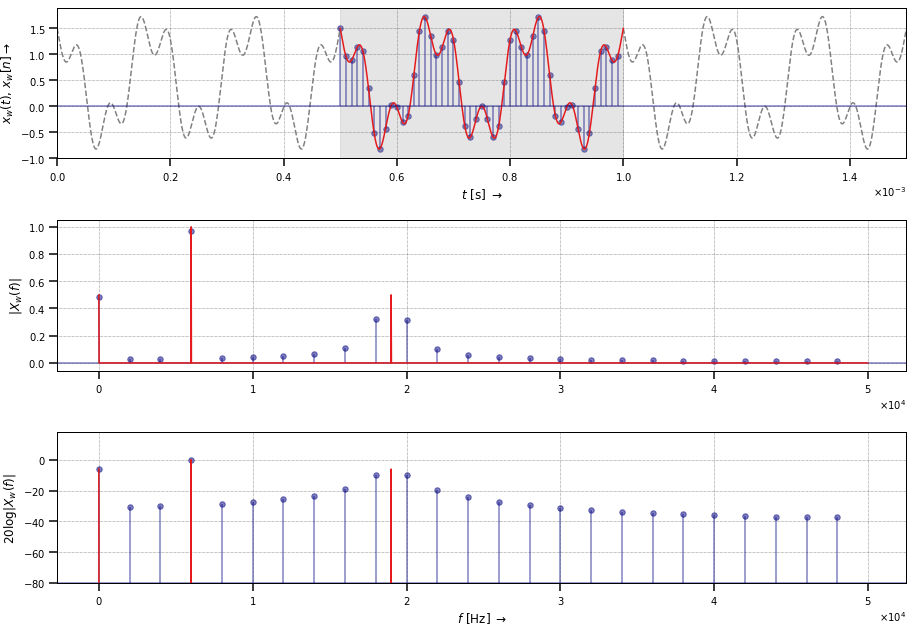

In [8]:
xtw = xt[N_FFT*OSR:2*N_FFT*OSR]  # Fenstere das analoge Signal durch "Ausstanzen"...
xn = xtw[::OSR] # ... und taste es ab: Nimm nur jedes OSR'te Sample
xtw = np.tile(xtw, L) # Wiederhole das analoge Signal L mal
tt = linspace(0,T_meas*100, N_FFT * 100, endpoint=False) # "analog" time for 100 windows giving a df = 1/(100T_meas)

fig2,ax2 = plt.subplots(nrows=3, ncols=1,**figsize)
ax2[0].plot(t[0:N_FFT*OSR], xtw[0:N_FFT*OSR],
             t[(2*N_FFT)*OSR:], xtw[(2*N_FFT)*OSR:], color='grey', linestyle='--')
ax2[0].plot(t[N_FFT*OSR:(2*N_FFT)*OSR], xtw[0:N_FFT*OSR])
stems(t[N_FFT*OSR:2*N_FFT*OSR:OSR],xt[N_FFT*OSR:2*N_FFT*OSR:OSR], ax=ax2[0], s=30, color=(0.0,0,0.5,0.5)) # x[n]
ax2[0].axvspan(t[N_FFT*OSR],t[(2*N_FFT)*OSR-1], alpha=0.2, color='grey') # markiere Fenster
ax2[0].set_xlabel(r'$t$ [s] $\rightarrow $');ax2[0].set_ylabel(r'$x_w(t),\, x_w[n] \rightarrow $');
ax2[0].set_xlim(0, L*T_meas)
# ----- Spektrum ------
Xn = 2 * np.abs(fft(xn, N_FFT)) / N_FFT     # Berechne / skaliere für einseitiges Spektrum
Xt = 2 * np.abs(fft(x(tt)))/len(tt)
Xn[0] = Xn[0] / 2                           # korrigiere DC-Wert
Xt[0] = Xt[0] / 2   
f =  fftfreq(len(Xn), T_S)                  # erzeuge N_FFT Freq.punkte bei [0... f_S/2[, [-f_S/2 ... f_s[]
fc = fftfreq(len(Xt), T_S)
stems(f[:N_FFT//2], Xn[:N_FFT//2], ax=ax2[1], s=30, color=(0.0,0,0.5,0.5))
ax2[1].plot(fc[:len(tt)//2], Xt[:len(tt)//2])
ax2[1].set_ylabel(r'$|X_w(f)|$')
# ----- log. Spektrum ------
stems(f[:N_FFT//2], 20*np.log10(Xn[:N_FFT//2]), ax=ax2[2], s=30, bottom=-80, color=(0.0,0,0.5,0.5))
ax2[2].plot(fc[:len(tt)//2], 20*np.log10(Xt[:len(tt)//2]))
ax2[2].set_xlabel(r'$f$ [Hz] $\rightarrow $'); ax2[2].set_ylabel(r'$20 \log|X_w(f)|$'); ax2[2].set_ylim(bottom=-80)

fig2.tight_layout();

Je nach Ihren Einstellungen wird das ausgeschnittene Fenster fehlerfrei wiederholt; in diesem Fall liegen Frequenz- und Amplitudenwerte der DFT exakt auf den Spektrallinien (periodisches Signal) der CFT. 

Frequenzen, die nicht genau auf dem Raster $k\cdot \Delta f$ der FFT liegen, können durch die DFT nicht exakt wiedergegeben werden. In diesem Fall treten die folgenden Fehler auf:

* **Frequenzfehler:** Spektrallinien treten bei leicht verfälschten Frequenzen auf.
* **Amplitudenfehler:** Die Amplitude der Spektrallinie ist verfälscht. Dies nennt man auch "Lattenzauneffekt" (picket fence effect) weil es vergleichbar ist mit dem Blick auf ein Gebirge durch einen Lattenzaun: Bergspitzen erscheinen niedriger, Täler weniger tief. Eine andere Bezeichnung ist "scalloping loss", benannt nach der gewellten Kante einer Muschel. Die Bezeichnung bezieht sich auf den resultierenden welligen Frequenzgang.
* **Leckeffekt:** Auch bei Frequenzen, bei denen gar keine Spektralkomponenten zu finden sein sollten, ist die Amplitude jetzt ungleich Null. Aufgrund des Leckeffekts können schwache Signale komplett untergehen.

Um die Verringerung dieser Fehler wird es im nächsten Notebook gehen.

## Fragen und Experimente
* Variieren Sie die Signalfrequenzen und schauen Sie sich die Effekte an.
* Wie groß ist der maximale Amplitudenfehler des Rechteckfensters [ausprobieren]?
* Vollziehen Sie die Berechnung der FFT der "analogen" und abgetasteten Signale nach.

***
**Copyright**

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.